Hello all,




In [2]:
#Import Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [3]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

#load the data and convert it into torch.Tensor. Labels need to be LongTensor.
#Normalize features between 0 and 1
transform = transforms.Normalize(0, 255, inplace=False)

train_df = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
submit_df = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

features_train = transform(torch.Tensor(np.reshape(train_df.iloc[:,1:].to_numpy(), (-1,1,28,28)))) #size=(42000,1,28,28)
labels_train = torch.LongTensor(train_df['label'].to_numpy())
features_submit = transform(torch.Tensor(np.reshape(submit_df.to_numpy(), (-1,28,28)))) #size=(28000,28,28)

#splitting training data into training, validation and test set
train_len = int(features_train.shape[0]*0.6) #size=(25200,1,28,28)
valid_len = int(features_train.shape[0]*0.2) #size=(8400,1,28,28)
train_set = torch.utils.data.TensorDataset(features_train[:train_len],labels_train[:train_len])
valid_set = torch.utils.data.TensorDataset(features_train[train_len:(train_len+valid_len)],labels_train[train_len:(train_len+valid_len)])
test_set = torch.utils.data.TensorDataset(features_train[(train_len+valid_len):],labels_train[(train_len+valid_len):])


#creating Dataloaders for training, validation and testing
train_loader = DataLoader(train_set, batch_size = 50)
valid_loader = DataLoader(valid_set, batch_size = 50)
test_loader = DataLoader(test_set, batch_size = 50)

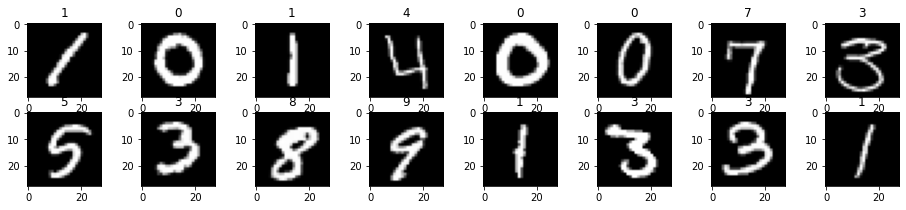

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
#Visualizing Some data

X = features_train[:16]
y = labels_train[:16]

plt.figure(figsize = (16, 3))

for i in range(16):
    if i >= 16:
        break
    plt.subplot(2, 8, i+1)
    plt.title(int(y[i]))
    plt.imshow(X[i].reshape(28,28),cmap="gray")

Plotting the train instance number 10: Label = 8


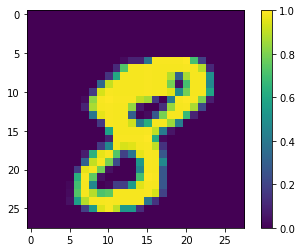

In [5]:
#1. Visualize train instance number n
n = 10
print('Plotting the train instance number {}: Label = {}'.format(n, labels_train[n]))
image1 = features_train[n].view(28,28)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(image1)

plt.colorbar()

In [7]:
import torch
from torch import nn
import torch.nn.functional as F


# define the CNN architecture
class CNN_classifier(nn.Module):
    def __init__(self):
        super(CNN_classifier, self).__init__()
        # convolutional layer (sees 1x28x28 image tensor)
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # convolutional layer (sees 32x14x14 image tensor)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        # convolutional layer (sees 32x7x7 image tensor --> 64, 3, 3)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 3 * 3 -> 256)
        self.fc1 = nn.Linear(64*3*3, 256)
        # linear layer (256 -> 10)
        self.fc2 = nn.Linear(256, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        # add dropout layer
        x = self.dropout(x)
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv2(x)))
        # add dropout layer
        x = self.dropout(x)
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv3(x)))
        # add dropout layer
        x = self.dropout(x)
        # flatten image input
        x = x.view(-1, 64*3*3)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

# create a complete CNN
model = CNN_classifier()
print(model)

CNN_classifier(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [8]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

#if gpu is available move model and criterion to gpuj
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [9]:
# number of epochs to train the model
n_epochs = 10
valid_plot = []
train_plot = []

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
        
        
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

    train_plot.append(train_loss)
    valid_plot.append(valid_loss)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_mnist_cnn.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.297623 	Validation Loss: 2.285797
Validation loss decreased (inf --> 2.285797).  Saving model ...
Epoch: 2 	Training Loss: 2.124134 	Validation Loss: 1.374900
Validation loss decreased (2.285797 --> 1.374900).  Saving model ...
Epoch: 3 	Training Loss: 0.940124 	Validation Loss: 0.429726
Validation loss decreased (1.374900 --> 0.429726).  Saving model ...
Epoch: 4 	Training Loss: 0.486769 	Validation Loss: 0.272764
Validation loss decreased (0.429726 --> 0.272764).  Saving model ...
Epoch: 5 	Training Loss: 0.343795 	Validation Loss: 0.197028
Validation loss decreased (0.272764 --> 0.197028).  Saving model ...
Epoch: 6 	Training Loss: 0.275235 	Validation Loss: 0.163205
Validation loss decreased (0.197028 --> 0.163205).  Saving model ...
Epoch: 7 	Training Loss: 0.235938 	Validation Loss: 0.138763
Validation loss decreased (0.163205 --> 0.138763).  Saving model ...
Epoch: 8 	Training Loss: 0.207737 	Validation Loss: 0.123090
Validation loss decreased (0.13876

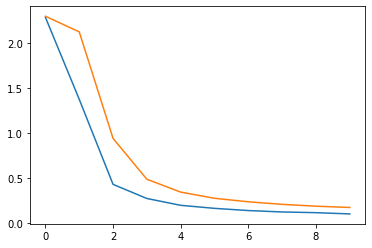

In [10]:
#Plotting training and validation loss
plt.plot(valid_plot)
plt.plot(train_plot)
plt.show()

In [90]:
# track test loss, correct_pred for accuary
# saving images that were wrongly predicted under false_images
test_loss = 0.0
correct_pred = 0
false_images = torch.empty((1, 28, 28))
false_preds = []
false_targets = []

model.eval()
# iterate over test data
for data, target in test_loader:
    if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_pred += torch.sum(pred == target).item()
    
    true_pred = pred==target
    for i, value in enumerate(true_pred):
        if value.item() == False:
            false_images = torch.cat((false_images, data[i]), dim=0)
            false_preds.append(pred[i])
            false_targets.append(target[i])

false_images = false_images[1:]
    
# print out average test loss and test accuracy
test_loss = test_loss/len(test_loader.dataset)
accuracy = correct_pred /len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
print('Accuracy: {:.2f}%'.format(accuracy*100))


Test Loss: 0.095064

Accuracy: 97.12%


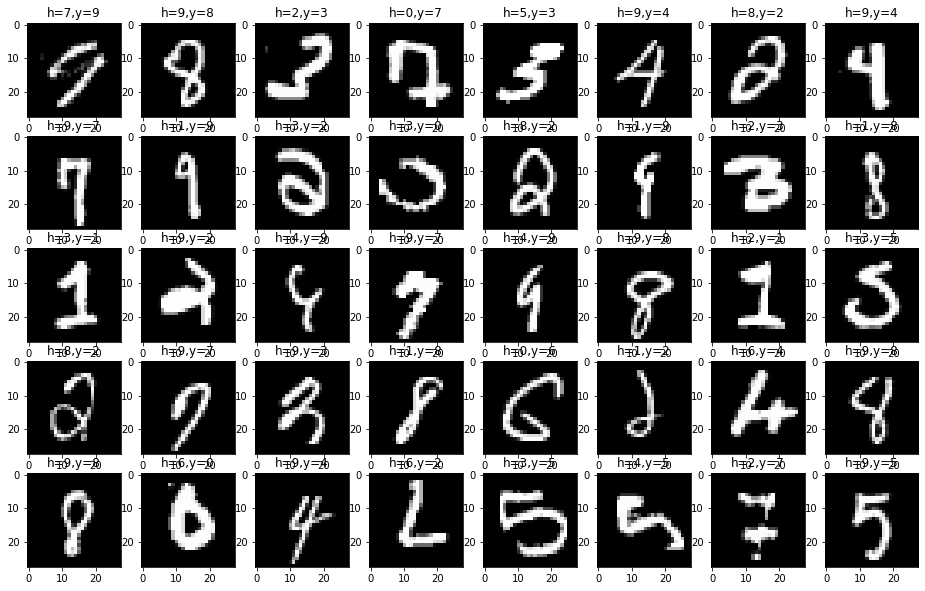

In [94]:
#Plotting falsely predicted images
X = false_images
prediction = false_preds
target = false_targets

plt.figure(figsize = (16, 10))

for i in range(40):
    if i >= 40:
        break
    plt.subplot(5, 8, i+1)
    plt.title('h={},y={}'.format(prediction[i].item(), target[i].item()))
    plt.imshow(X[i].reshape(28,28),cmap="gray")

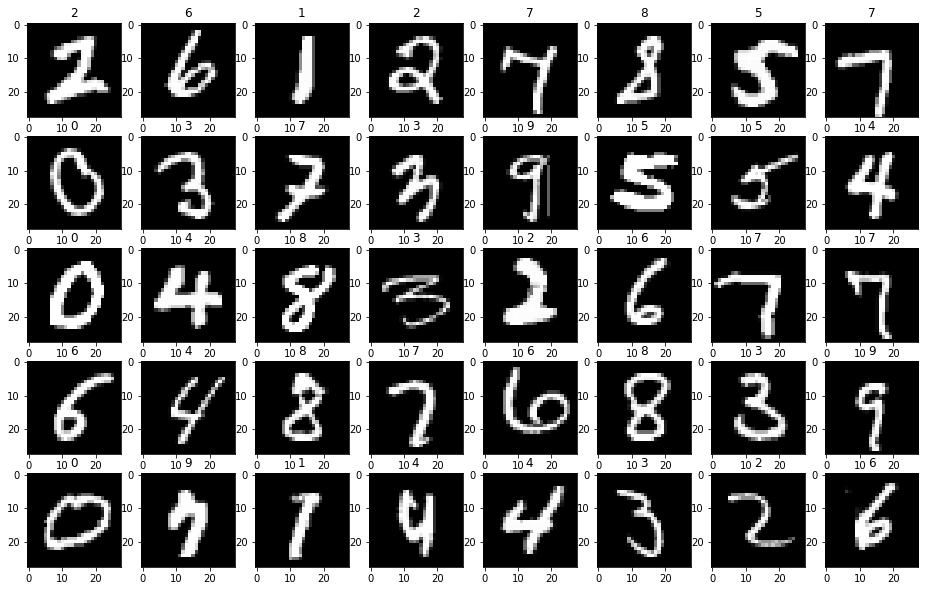

In [95]:
#Visualizing some correct predictions
data_iter = iter(valid_loader)
data, target = next(data_iter)
    
if torch.cuda.is_available():
    data = data.cuda()

output = model(data)
_, pred = torch.max(output, 1) 

if torch.cuda.is_available():
    pred = pred.cpu()
    data = data.cpu()

X = data[:40]

plt.figure(figsize = (16, 10))

for i in range(40):
    if i >= 40:
        break
    plt.subplot(5, 8, i+1)
    plt.title(pred[i].item())
    plt.imshow(X[i].reshape(28,28),cmap="gray")

In [ ]:
#submision
data = features_submit.view(-1,1,28,28)
if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
output = model(data)
score, predictions = torch.topk(output, 1)

In [ ]:
predictions.size()
predictions = predictions.cpu()

In [ ]:
ImageId = np.arange(1,predictions.size()[0]+1)
Label = predictions.view(predictions.size()[0]).numpy()
new_submission = pd.DataFrame({'ImageId': ImageId, 'Label': Label})
new_submission.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

In [ ]:
new_submission